# GDR RSD School - Hackathon - Python load injection

This notebook presents how to use a home-made python script to inject load in the system.

We run 1 instance of the python script for each CoAP server available (M3 sensor).

2 main parameters dictates the execution:

    - duration: describes for how many seconds the script will run
    - sleep_interval: the interval between requests, smaller sleep intervals mean higher load

## Parameters of this notebook

This allows you to modify them through papermill.

In [1]:
%cd ../../
%pwd

/home/jovyan


'/home/jovyan'

In [2]:
import enoslib as en

import logging
import sys
import datetime
import pathlib
import uuid

The Vagrant executable cannot be found. Please check if it is in the system path.


Note: Openstack clients not installed


---
This cell presents all the paramters used in this notebook that can be modified through papermill.

In [3]:
#parameters to this notebook
output_dir = "data/raw/%s/%s" % (str(datetime.date.today()), str(uuid.uuid4())) # location for output files
br_image="data/firmware/contikimac/border-router.iotlab-m3"      # border router firmware
er_image="data/firmware/contikimac/er-example-server.iotlab-m3"  # sensor/coap server firmware
iotlab_site="grenoble" # IoT-LAB site
iotlab_nodes=4         # number of nodes in IoT-LAB platform, 1 border router, N - 1 sensors
iotlab_ipv6_net="2001:660:5307:3130::"  # IPv6 subnet, depends on the site
job_name="hackathon"   # job_name to submit to platforms
sleep_interval=5       # interval between requests
duration=300           # duration of load injection
free_resources=True    # destroy job in testbeds at the end
g5k_nodes=1

In [4]:
# Parameters
output_dir = "data/raw/2021-09-07/6e4469da-9fbf-4a5b-9dfb-1fc81eb905dd"
er_image = "data/firmware/contikimac/er-example-server.iotlab-m3"
br_image = "data/firmware/contikimac/border-router.iotlab-m3"
free_resources = True
duration = 300
sleep_interval = 0.05
iotlab_nodes = 4
iotlab_site = "grenoble"
g5k_nodes = 1


## Initialization

Some information about this experiment

In [5]:
# creating output folder
pathlib.Path(output_dir).mkdir(exist_ok=True, parents=True)
print("Starting new experiment %s" % (output_dir))

Starting new experiment data/raw/2021-09-07/6e4469da-9fbf-4a5b-9dfb-1fc81eb905dd


---
Configuring logging: save DEBUG to a file and INFO to stdout.

In [6]:
log = logging.getLogger()
log.setLevel(logging.DEBUG)

formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fileHandler = logging.FileHandler("%s/debug.log" % (output_dir), 'a')
fileHandler.setLevel(logging.DEBUG)
fileHandler.setFormatter(formatter)
log.addHandler(fileHandler)

cformat = logging.Formatter("[%(levelname)8s] : %(message)s")
consoleHandler = logging.StreamHandler(sys.stdout)
consoleHandler.setFormatter(cformat)
consoleHandler.setLevel(logging.INFO)
log.addHandler(consoleHandler)

## IoT-LAB

### Describing the resources

Get list of IoT-LAB nodes available

In [7]:
iotlab_nodes_list = []

with open(".iotlab_nodes", "r") as f:
    iotlab_nodes_list = f.read().splitlines()

print("Available nodes: %s" % str(iotlab_nodes_list))
br_nodes = iotlab_nodes_list[0:1] # 1 border router
coap_nodes = iotlab_nodes_list[1:iotlab_nodes] # n - 1 CoAP servers

print("Border-router: %s" % str(br_nodes))
print("CoAP servers: %s" % str(coap_nodes))

Available nodes: ['m3-15.grenoble.iot-lab.info', 'm3-16.grenoble.iot-lab.info', 'm3-17.grenoble.iot-lab.info', 'm3-18.grenoble.iot-lab.info', 'm3-19.grenoble.iot-lab.info']
Border-router: ['m3-15.grenoble.iot-lab.info']
CoAP servers: ['m3-16.grenoble.iot-lab.info', 'm3-17.grenoble.iot-lab.info', 'm3-18.grenoble.iot-lab.info']


Describing resources usinb EnOSlib.

In [8]:
iotlab_dict = {
    "job_name": job_name,
    "walltime": "01:00",       # duration of the experiment: e.g. 1 hour
    "resources":
    {"machines": [
        {
            "roles": ["coap-server"],      # user-defined role for these nodes: CoAP servers
            "hostname": coap_nodes,            
            "image": er_image,             # initial image to be installed on the nodes
            "profile": "energy",           # monitoring profile, defined below
        },
        {
            "roles": ["border-router"],   # user-defined string, 1 border-router in our example
            "hostname": br_nodes,                        
            "image": br_image,
            "profile": "energy",
        },
    ]},
    "monitoring": {
        "profiles": [{
            "name": "energy",           # More details: https://www.iot-lab.info/legacy/tutorials/monitoring-consumption-m3/index.html
            "archi": "m3",
            "consumption": {
                "current": True,
                "power": True,
                "voltage": True,
                "period": 8244,         # interval between measurements in us
                "average": 4,
            },
        }]
    }
}

# creating the object for our reservation
# the nodes aren't avaible until you call init() on these objects
iotlab_conf = en.IotlabConf.from_dictionary(iotlab_dict)
iotlab_provider = en.Iotlab(iotlab_conf)
iotlab_conf

Conf@0x7f16de8d5820
{
    "job_name": "hackathon",
    "walltime": "01:00",
    "resources": {
        "machines": [
            {
                "roles": [
                    "coap-server"
                ],
                "image": "data/firmware/contikimac/er-example-server.iotlab-m3",
                "profile": "energy",
                "hostname": [
                    "m3-16.grenoble.iot-lab.info",
                    "m3-17.grenoble.iot-lab.info",
                    "m3-18.grenoble.iot-lab.info"
                ]
            },
            {
                "roles": [
                    "border-router"
                ],
                "image": "data/firmware/contikimac/border-router.iotlab-m3",
                "profile": "energy",
                "hostname": [
                    "m3-15.grenoble.iot-lab.info"
                ]
            }
        ],
        "networks": []
    },
    "monitoring": {
        "profiles": [
            {
                "name": "energy",
                "archi": "m3",
                "consumption": {
                    "current": true,
                    "power": true,
                    "voltage": true,
                    "period": 8244,
                    "average": 4
                }
            }
        ]
    }
}

### Reserving the resources

In [9]:
iotlab_roles, iotlab_networks = iotlab_provider.init()
iotlab_roles

[    INFO] : Profile: energy, already exists. Skipping creation.


[    INFO] : Waiting for job id (276590) to be in running state


[    INFO] : Job id (276590) is running


[    INFO] : Finished reserving nodes: hosts [], sensors [<IotlabSensor(roles=['coap-server'], address=m3-16.grenoble.iot-lab.info, site=grenoble, uid=a269)>image=data/firmware/contikimac/er-example-server.iotlab-m3)>, <IotlabSensor(roles=['coap-server'], address=m3-17.grenoble.iot-lab.info, site=grenoble, uid=a172)>image=data/firmware/contikimac/er-example-server.iotlab-m3)>, <IotlabSensor(roles=['coap-server'], address=m3-18.grenoble.iot-lab.info, site=grenoble, uid=b679)>image=data/firmware/contikimac/er-example-server.iotlab-m3)>, <IotlabSensor(roles=['border-router'], address=m3-15.grenoble.iot-lab.info, site=grenoble, uid=c280)>image=data/firmware/contikimac/border-router.iotlab-m3)>]


[    INFO] : Flashing image (data/firmware/contikimac/er-example-server.iotlab-m3) on nodes (['m3-16.grenoble.iot-lab.info', 'm3-17.grenoble.iot-lab.info', 'm3-18.grenoble.iot-lab.info'])


[    INFO] : Flashing image (data/firmware/contikimac/border-router.iotlab-m3) on nodes (['m3-15.grenoble.iot-lab.info'])


{'coap-server': [<IotlabSensor(roles=['coap-server'], address=m3-16.grenoble.iot-lab.info, site=grenoble, uid=a269)>image=data/firmware/contikimac/er-example-server.iotlab-m3)>, <IotlabSensor(roles=['coap-server'], address=m3-17.grenoble.iot-lab.info, site=grenoble, uid=a172)>image=data/firmware/contikimac/er-example-server.iotlab-m3)>, <IotlabSensor(roles=['coap-server'], address=m3-18.grenoble.iot-lab.info, site=grenoble, uid=b679)>image=data/firmware/contikimac/er-example-server.iotlab-m3)>], 'border-router': [<IotlabSensor(roles=['border-router'], address=m3-15.grenoble.iot-lab.info, site=grenoble, uid=c280)>image=data/firmware/contikimac/border-router.iotlab-m3)>]}

### Setting up the IPv6 connectivity

**Bridging M3 wireless network to internet**.

Based on the tutorial: https://www.iot-lab.info/legacy/tutorials/contiki-coap-m3/index.html

---
Run the tunslip6 in the frontend node. This daemon will connect your border router with the outside world.

Each group need to select a different network for communication

More details in: https://www.iot-lab.info/legacy/tutorials/understand-ipv6-subnetting-on-the-fit-iot-lab-testbed/index.html

In [10]:
import iotlabcli.auth
iotlab_user, _ = iotlabcli.auth.get_user_credentials()   # get your credentials from .iotlabrc to connect to frontend node.

fit_frontend = en.Host("%s.iot-lab.info" % iotlab_site, alias=iotlab_site, user=iotlab_user) 

---
Reseting border router node and run the tunslip command

In [11]:
iotlab_roles["border-router"][0].reset()

en.run('pgrep -u "$(whoami)" tunslip6 | xargs -r kill', fit_frontend) # kill running tunslip if any
# run tunslip6 command in background
tun_cmd = "sudo tunslip6.py -v2 -L -a %s -p 20000 %s/64 > tunslip.output 2>&1" % (iotlab_roles["border-router"][0].alias, iotlab_ipv6_net)
en.run_command(tun_cmd, roles=fit_frontend, background=True)

for sensor in iotlab_roles["coap-server"]:
    sensor.reset()

[    INFO] : Executing command (reset) on nodes (['m3-15.grenoble.iot-lab.info'])


[WARNING]: No inventory was parsed, only implicit localhost is available


None

PLAY [all] *********************************************************************



TASK [pgrep -u "$(whoami)" tunslip6 | xargs -r kill] ***************************


 [started TASK: pgrep -u "$(whoami)" tunslip6 | xargs -r kill on grenoble]


[DEPRECATION WARNING]: Distribution debian 10.7 on host grenoble should use 
/usr/bin/python3, but is using /usr/bin/python for backward compatibility with 
prior Ansible releases. A future Ansible release will default to using the 
discovered platform python for this host. See https://docs.ansible.com/ansible/
2.10/reference_appendices/interpreter_discovery.html for more information. This
 feature will be removed in version 2.12. Deprecation warnings can be disabled 
by setting deprecation_warnings=False in ansible.cfg.


changed: [grenoble]


None

PLAY [all] *********************************************************************



TASK [sudo tunslip6.py -v2 -L -a m3-15 -p 20000 2001:660:5307:3130::/64 > tunslip.output 2>&1] ***


 [started TASK: sudo tunslip6.py -v2 -L -a m3-15 -p 20000 2001:660:5307:3130::/64 > tunslip.output 2>&1 on grenoble]


changed: [grenoble]


[    INFO] : Executing command (reset) on nodes (['m3-16.grenoble.iot-lab.info'])


[    INFO] : Executing command (reset) on nodes (['m3-17.grenoble.iot-lab.info'])


[    INFO] : Executing command (reset) on nodes (['m3-18.grenoble.iot-lab.info'])


---
Looking output of tunslip command to check status and get border router IPv6 address.

In [12]:
from retry import retry
import re
@retry(AttributeError, tries=5, delay=1, backoff=2)
def get_br_ipv6_address(frontend):
    results = en.run("cat tunslip.output", [frontend])
    out = results[0].stdout
    # print(out)
    match = re.search(rf'Server IPv6 addresses:\n.+(2001[0-9a-fA-F:]+)\n', out, re.MULTILINE|re.DOTALL)
    return match.groups()[0]

br_ipv6 = get_br_ipv6_address(fit_frontend)
print("Border Router IPv6 address from tunslip output: %s" % br_ipv6)

None

PLAY [all] *********************************************************************



TASK [cat tunslip.output] ******************************************************


 [started TASK: cat tunslip.output on grenoble]


changed: [grenoble]


Border Router IPv6 address from tunslip output: 2001:660:5307:3130::c280


## Grid5000 resources

### Describing the resources

In [13]:
g5k_dict = {
    "job_type": "allow_classic_ssh",
    "job_name": job_name,
    "walltime": "01:00:00",
    "resources": {
        "machines": [
            {
                "roles": ["server"],
                "cluster": "paravance",             # note that the cluster is hardcoded here, you may want to change it
                "nodes": g5k_nodes,
                "primary_network": "default",
            },
        ],
        "networks": [
            {"id": "default", "type": "prod", "roles": ["prod"], "site": "rennes"}
        ],
    },
}
g5k_conf = en.G5kConf.from_dictionnary(g5k_dict)
g5k_provider = en.G5k(g5k_conf)
g5k_conf

Conf@0x7f16de6d1670
{
    "dhcp": true,
    "force_deploy": false,
    "env_name": "debian10-x64-nfs",
    "job_name": "hackathon",
    "job_type": [
        "allow_classic_ssh"
    ],
    "key": "/home/jovyan/.ssh/id_rsa.pub",
    "queue": "default",
    "walltime": "01:00:00",
    "resources": {
        "machines": [
            {
                "roles": [
                    "server"
                ],
                "primary_network": "default",
                "secondary_networks": [],
                "cluster": "paravance",
                "nodes": 1
            }
        ],
        "networks": [
            {
                "id": "default",
                "type": "prod",
                "roles": [
                    "prod"
                ],
                "site": "rennes"
            }
        ]
    }
}

### Reserving the resources

In [14]:
g5k_roles, g5k_networks = g5k_provider.init()
en.run_command("dhclient -6 br0", roles=g5k_roles)
g5k_roles = en.sync_info(g5k_roles, g5k_networks) # get IPV6 addresses
g5k_roles

[    INFO] : Reloading hackathon from grenoble


[    INFO] : Reloading hackathon from lille


[    INFO] : Reloading hackathon from luxembourg


[    INFO] : Reloading hackathon from lyon


[    INFO] : Reloading hackathon from nancy


[    INFO] : Reloading hackathon from nantes


[    INFO] : Reloading hackathon from rennes


[    INFO] : Reloading 1817482 from rennes


[    INFO] : Reloading hackathon from sophia


[ WARNING] : Retrying (Retry(total=4, connect=5, read=4, redirect=None, status=None)) after connection broken by 'ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))': /stable/sites/rennes/jobs/1817482


[    INFO] : Waiting for 1817482 on rennes [2021-09-07 09:34:22]


[    INFO] : All jobs are Running !


None

PLAY [all] *********************************************************************



TASK [dhclient -6 br0] *********************************************************


 [started TASK: dhclient -6 br0 on paravance-45.rennes.grid5000.fr]


[DEPRECATION WARNING]: Distribution debian 10.10 on host 
paravance-45.rennes.grid5000.fr should use /usr/bin/python3, but is using 
/usr/bin/python for backward compatibility with prior Ansible releases. A 
future Ansible release will default to using the discovered platform python for
 this host. See https://docs.ansible.com/ansible/2.10/reference_appendices/inte
rpreter_discovery.html for more information. This feature will be removed in 
version 2.12. Deprecation warnings can be disabled by setting 
deprecation_warnings=False in ansible.cfg.


changed: [paravance-45.rennes.grid5000.fr]


None

PLAY [all] *********************************************************************



TASK [hostname] ****************************************************************


 [started TASK: hostname on paravance-45.rennes.grid5000.fr]


changed: [paravance-45.rennes.grid5000.fr]



PLAY [Gather facts for all hosts] **********************************************



TASK [Gathering Facts] *********************************************************


ok: [paravance-45.rennes.grid5000.fr]



TASK [setup] *******************************************************************


ok: [paravance-45.rennes.grid5000.fr]



PLAY [Utils functions] *********************************************************



TASK [Gathering Facts] *********************************************************


ok: [paravance-45.rennes.grid5000.fr]



TASK [utils : include] *********************************************************


included: /opt/conda/lib/python3.9/site-packages/enoslib/ansible/roles/utils/tasks/check_network.yml for paravance-45.rennes.grid5000.fr



TASK [utils : Dump network information in a file] ******************************


changed: [paravance-45.rennes.grid5000.fr -> localhost]



TASK [utils : Create the fake interfaces] **************************************


skipping: [paravance-45.rennes.grid5000.fr]



PLAY RECAP *********************************************************************


paravance-45.rennes.grid5000.fr : ok=5    changed=1    unreachable=0    failed=0    skipped=1    rescued=0    ignored=0   


{'server': [Host(address='paravance-45.rennes.grid5000.fr', alias='paravance-45.rennes.grid5000.fr', user='root', keyfile=None, port=None, extra={}, net_devices={NetDevice(name='eno2', addresses=set()), NetDevice(name='eno3', addresses=set()), NetDevice(name='eno4', addresses=set()), BridgeDevice(name='br0', addresses={IPAddress(network=None, ip=IPv6Interface('fe80::eef4:bbff:fed0:ee20/64')), IPAddress(network=<enoslib.infra.enos_g5k.objects.G5kEnosProd6Network object at 0x7f16dde9ca90>, ip=IPv6Interface('2001:660:4406:700:1::2d/128')), IPAddress(network=<enoslib.infra.enos_g5k.objects.G5kEnosProd4Network object at 0x7f16de76afd0>, ip=IPv4Interface('172.16.96.45/20'))}, bridged=['eno1']), NetDevice(name='lo', addresses={IPAddress(network=None, ip=IPv6Interface('::1/128')), IPAddress(network=None, ip=IPv4Interface('127.0.0.1/8'))}), NetDevice(name='eno1', addresses=set())})]}

---
Install aiocoap package used to send CoAP requests to M3 sensors.

In [15]:
with en.play_on(pattern_hosts="server", roles=g5k_roles) as p:
    p.shell("pip3 install aiocoap[all]")

None

PLAY [server] ******************************************************************



TASK [pip3 install aiocoap[all]] ***********************************************


 [started TASK: pip3 install aiocoap[all] on paravance-45.rennes.grid5000.fr]


changed: [paravance-45.rennes.grid5000.fr]


## Injecting load in G5K server

First, we need to get the IPv6 address of CoAP sensors.
For that, request it through Border Router's web interface,

In [16]:
print("View BR’s web-interface: ")
results = en.run('lynx --dump http://[%s]' % br_ipv6, [fit_frontend])
results

View BR’s web-interface: 
None

PLAY [all] *********************************************************************



TASK [lynx --dump http://[2001:660:5307:3130::c280]] ***************************


 [started TASK: lynx --dump http://[2001:660:5307:3130::c280] on grenoble]


changed: [grenoble]


CommandResult(host='grenoble', task='lynx --dump http://[2001:660:5307:3130::c280]', status='OK', payload={'changed': True, 'end': '2021-09-07 11:54:17.575780', 'stdout': '   Neighbors\nfe80::a172\nfe80::b679\nfe80::a269\n\n   Routes\n2001:660:5307:3130::a269/128 (via fe80::a269) 1798s\n2001:660:5307:3130::a172/128 (via fe80::a172) 1796s\n2001:660:5307:3130::b679/128 (via fe80::b679) 1785s', 'cmd': 'lynx --dump http://[2001:660:5307:3130::c280]', 'rc': 0, 'start': '2021-09-07 11:54:17.041573', 'stderr': '', 'delta': '0:00:00.534207', 'invocation': {'module_args': {'creates': None, 'executable': None, '_uses_shell': True, 'strip_empty_ends': True, '_raw_params': 'lynx --dump http://[2001:660:5307:3130::c280]', 'removes': None, 'argv': None, 'warn': True, 'chdir': None, 'stdin_add_newline': True, 'stdin': None}}, 'stdout_lines': ['   Neighbors', 'fe80::a172', 'fe80::b679', 'fe80::a269', '', '   Routes', '2001:660:5307:3130::a269/128 (via fe80::a269) 1798s', '2001:660:5307:3130::a172/128 (via fe80::a172) 1796s', '2001:660:5307:3130::b679/128 (via fe80::b679) 1785s'], 'stderr_lines': [], 'ansible_facts': {'discovered_interpreter_python': '/usr/bin/python'}, '_ansible_no_log': False})

---
Gets the suffix of sensors' IPv6 addresses.

In [17]:
out = results[0].stdout
node_uids = re.findall(r'fe80::(\w{4})', out, re.MULTILINE|re.DOTALL)
node_uids = list(set(node_uids))
print(node_uids)

['a269', 'a172', 'b679']


---
Inject load by requesting pressure measure for each sensor.

A CSV file, named elapsed_time.csv, is created with the output of our commands.

In [18]:
import datetime
import time
outfile = output_dir + "/elapsed_time.csv"
#copy load injection python script
with en.play_on(roles=g5k_roles) as p:
    p.copy(src="src/read_sensor.py", dest="/tmp/read_sensor.py", mode="0777")

# run 1 instance of the file for each sensor, saving output in outfile
with open(outfile, "w") as f:
    f.write("timestamp,n,node,ok,elapsed\n")
    cmd = ""
    for node in node_uids:
        node_addr = iotlab_ipv6_net + node
        cmd += 'timeout %d python3 -u /tmp/read_sensor.py -a %s -s %f > /tmp/%s.txt &' % (duration, node_addr, sleep_interval, node)
    cmd += "wait"
    print(cmd)
    _ = en.run_command(cmd, roles=g5k_roles)
    for node in node_uids:
        results = en.run_command("cat /tmp/%s.txt" % node, roles=g5k_roles)
        for res in results:
            print(res.stdout)
            f.write(res.stdout)
            f.write('\n')


None

PLAY [all] *********************************************************************



TASK [copy] ********************************************************************


 [started TASK: copy on paravance-45.rennes.grid5000.fr]


ok: [paravance-45.rennes.grid5000.fr]


timeout 300 python3 -u /tmp/read_sensor.py -a 2001:660:5307:3130::a269 -s 0.050000 > /tmp/a269.txt &timeout 300 python3 -u /tmp/read_sensor.py -a 2001:660:5307:3130::a172 -s 0.050000 > /tmp/a172.txt &timeout 300 python3 -u /tmp/read_sensor.py -a 2001:660:5307:3130::b679 -s 0.050000 > /tmp/b679.txt &wait
None

PLAY [all] *********************************************************************



TASK [timeout 300 python3 -u /tmp/read_sensor.py -a 2001:660:5307:3130::a269 -s 0.050000 > /tmp/a269.txt &timeout 300 python3 -u /tmp/read_sensor.py -a 2001:660:5307:3130::a172 -s 0.050000 > /tmp/a172.txt &timeout 300 python3 -u /tmp/read_sensor.py -a 2001:660:5307:3130::b679 -s 0.050000 > /tmp/b679.txt &wait] ***


 [started TASK: timeout 300 python3 -u /tmp/read_sensor.py -a 2001:660:5307:3130::a269 -s 0.050000 > /tmp/a269.txt &timeout 300 python3 -u /tmp/read_sensor.py -a 2001:660:5307:3130::a172 -s 0.050000 > /tmp/a172.txt &timeout 300 python3 -u /tmp/read_sensor.py -a 2001:660:5307:3130::b679 -s 0.050000 > /tmp/b679.txt &wait on paravance-45.rennes.grid5000.fr]


changed: [paravance-45.rennes.grid5000.fr]


None

PLAY [all] *********************************************************************



TASK [cat /tmp/a269.txt] *******************************************************


 [started TASK: cat /tmp/a269.txt on paravance-45.rennes.grid5000.fr]


changed: [paravance-45.rennes.grid5000.fr]


1631008462.847579,0,2001:660:5307:3130::a269,1,0.210985
1631008463.026729,1,2001:660:5307:3130::a269,1,0.128875
1631008463.358531,2,2001:660:5307:3130::a269,1,0.281569
1631008463.544437,3,2001:660:5307:3130::a269,1,0.135666
1631008466.366658,4,2001:660:5307:3130::a269,1,2.772028
1631008466.806144,5,2001:660:5307:3130::a269,1,0.389249
1631008466.991896,6,2001:660:5307:3130::a269,1,0.135549
1631008467.257974,7,2001:660:5307:3130::a269,1,0.215842
1631008467.455931,8,2001:660:5307:3130::a269,1,0.147716
1631008467.593452,9,2001:660:5307:3130::a269,1,0.087293
1631008468.085941,10,2001:660:5307:3130::a269,1,0.442247
1631008468.365957,11,2001:660:5307:3130::a269,1,0.229805
1631008468.504228,12,2001:660:5307:3130::a269,1,0.088035
1631008468.641077,13,2001:660:5307:3130::a269,1,0.086556
1631008468.778101,14,2001:660:5307:3130::a269,1,0.086787
1631008468.918181,15,2001:660:5307:3130::a269,1,0.089777
1631008469.117859,16,2001:660:5307:3130::a269,1,0.149453
1631008469.259760,17,2001:660:5307:3130::


TASK [cat /tmp/a172.txt] *******************************************************


 [started TASK: cat /tmp/a172.txt on paravance-45.rennes.grid5000.fr]


changed: [paravance-45.rennes.grid5000.fr]


1631008462.895528,0,2001:660:5307:3130::a172,1,0.258611
1631008463.036542,1,2001:660:5307:3130::a172,1,0.090768
1631008463.543241,2,2001:660:5307:3130::a172,1,0.456518
1631008463.714450,3,2001:660:5307:3130::a172,1,0.121002
1631008463.954620,4,2001:660:5307:3130::a172,1,0.189944
1631008464.093669,5,2001:660:5307:3130::a172,1,0.088813
1631008464.306474,6,2001:660:5307:3130::a172,1,0.162631
1631008464.542996,7,2001:660:5307:3130::a172,1,0.186285
1631008464.753551,8,2001:660:5307:3130::a172,1,0.160313
1631008465.016536,9,2001:660:5307:3130::a172,1,0.212752
1631008465.191108,10,2001:660:5307:3130::a172,1,0.124329
1631008465.374448,11,2001:660:5307:3130::a172,1,0.133094
1631008465.674315,12,2001:660:5307:3130::a172,1,0.249661
1631008465.863225,13,2001:660:5307:3130::a172,1,0.138663
1631008466.054705,14,2001:660:5307:3130::a172,1,0.141241
1631008466.230585,15,2001:660:5307:3130::a172,1,0.125637
1631008466.387207,16,2001:660:5307:3130::a172,1,0.106318
1631008466.594209,17,2001:660:5307:3130::


TASK [cat /tmp/b679.txt] *******************************************************


 [started TASK: cat /tmp/b679.txt on paravance-45.rennes.grid5000.fr]


changed: [paravance-45.rennes.grid5000.fr]


1631008463.097305,0,2001:660:5307:3130::b679,1,0.462177
1631008463.368388,1,2001:660:5307:3130::b679,1,0.220822
1631008463.728388,2,2001:660:5307:3130::b679,1,0.309721
1631008463.911416,3,2001:660:5307:3130::b679,1,0.132790
1631008464.086927,4,2001:660:5307:3130::b679,1,0.125268
1631008464.409539,5,2001:660:5307:3130::b679,1,0.272374
1631008464.547394,6,2001:660:5307:3130::b679,1,0.087599
1631008464.861188,7,2001:660:5307:3130::b679,1,0.263583
1631008465.058339,8,2001:660:5307:3130::b679,1,0.146906
1631008465.212321,9,2001:660:5307:3130::b679,1,0.103766
1631008465.385351,10,2001:660:5307:3130::b679,1,0.122785
1631008465.588445,11,2001:660:5307:3130::b679,1,0.152850
1631008465.729326,12,2001:660:5307:3130::b679,1,0.090624
1631008465.865369,13,2001:660:5307:3130::b679,1,0.085800
1631008466.098541,14,2001:660:5307:3130::b679,1,0.182956
1631008466.428172,15,2001:660:5307:3130::b679,1,0.279395
1631008466.570129,16,2001:660:5307:3130::b679,1,0.091715
1631008466.748064,17,2001:660:5307:3130::

In [19]:
output_dir

'data/raw/2021-09-07/6e4469da-9fbf-4a5b-9dfb-1fc81eb905dd'

## Collect data

### FIT/IoT-LAB

EnOSlib provides a convenient way to collect the logs generated by the platform about your experiment.

It will generate a tar.gz containing all files under your .~/iot-lab/exp_id folder in the IoT-LAB frontend.

In [20]:
iotlab_provider.collect_data_experiment(exp_dir=output_dir)

[    INFO] : API exp info saved in data/raw/2021-09-07/6e4469da-9fbf-4a5b-9dfb-1fc81eb905dd/276590.tar.gz file.


[    INFO] : Collecting experiment data from sites. Saving in folder: data/raw/2021-09-07/6e4469da-9fbf-4a5b-9dfb-1fc81eb905dd


None

PLAY [all] *********************************************************************



TASK [cd .iot-lab/; tar --ignore-command-error -czf 276590-grenoble.iot-lab.info.tar.gz 276590/] ***


 [started TASK: cd .iot-lab/; tar --ignore-command-error -czf 276590-{{ inventory_hostname }}.tar.gz 276590/ on grenoble.iot-lab.info]


[DEPRECATION WARNING]: Distribution debian 10.7 on host grenoble.iot-lab.info 
should use /usr/bin/python3, but is using /usr/bin/python for backward 
compatibility with prior Ansible releases. A future Ansible release will 
default to using the discovered platform python for this host. See https://docs
.ansible.com/ansible/2.10/reference_appendices/interpreter_discovery.html for 
more information. This feature will be removed in version 2.12. Deprecation 
warnings can be disabled by setting deprecation_warnings=False in ansible.cfg.


changed: [grenoble.iot-lab.info]



TASK [fetch] *******************************************************************


 [started TASK: fetch on grenoble.iot-lab.info]


changed: [grenoble.iot-lab.info]



TASK [cd .iot-lab/; rm -f 276590-grenoble.iot-lab.info.tar.gz] *****************


 [started TASK: cd .iot-lab/; rm -f 276590-{{ inventory_hostname }}.tar.gz on grenoble.iot-lab.info]


changed: [grenoble.iot-lab.info]


---
Extract the available data.

In [21]:
import tarfile
job_id = iotlab_provider.client.get_job_id()
tar = tarfile.open("%s/%s-%s.iot-lab.info.tar.gz" % (output_dir, job_id, iotlab_site))
tar.extractall(path=output_dir)
tar.close()

## Analyze data

### Elapsed time

Reading the csv file with the result of our test.

In [22]:
%load_ext rpy2.ipython
import pandas
df = pandas.read_csv(output_dir + "/elapsed_time.csv")
df.head()

[    INFO] : NumExpr defaulting to 8 threads.


timestamp  n                      node  ok   elapsed
0  1.631008e+09  0  2001:660:5307:3130::a269   1  0.210985
1  1.631008e+09  1  2001:660:5307:3130::a269   1  0.128875
2  1.631008e+09  2  2001:660:5307:3130::a269   1  0.281569
3  1.631008e+09  3  2001:660:5307:3130::a269   1  0.135666
4  1.631008e+09  4  2001:660:5307:3130::a269   1  2.772028

---
Using R and ggplot to plot the elapsed time.

The dataframe is available to R through the *R -i df* command.

[ WARNING] : R[write to console]: 
Attaching package: ‘dplyr’




[ WARNING] : R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag




[ WARNING] : R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




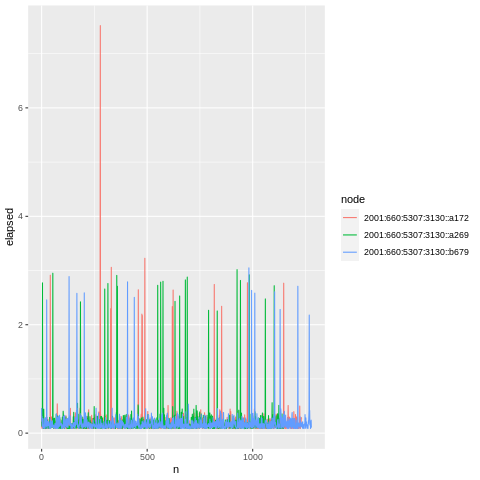

In [23]:
%%R -i df
library("ggplot2")
library("dplyr")
df %>% filter(ok == 1) %>%
ggplot(aes(x=n, y=elapsed, color=node)) + geom_line()

### Energy comsumption

For the energy, we use the **oml_plot_tools** (https://github.com/iot-lab/oml-plot-tools) to read the raw data and to create the corresponding dataframe.

This dataframe is saved as a CSV file to be read by other notebooks later.

In [24]:
import oml_plot_tools.consum
import pandas as pd
df = pd.DataFrame()
for node in iotlab_roles["coap-server"]:
    nodename = node.alias.replace('-', "_")
    filename = "%s/%s/consumption/%s.oml" % (output_dir, job_id, nodename)
    print(filename)
    data = oml_plot_tools.consum.oml_load(filename)
    temp = pd.DataFrame(data=data)
    temp['node'] = nodename
    temp = temp[temp['t_s'] > max(temp['t_s']) - duration]
    df =  pd.concat([df, temp])

df.to_csv(output_dir + "/energy.csv")
df
#oml_plot_tools.consum.consumption_plot(data, "My Plot:", 'all')

data/raw/2021-09-07/6e4469da-9fbf-4a5b-9dfb-1fc81eb905dd/276590/consumption/m3_16.oml


/opt/conda/lib/python3.9/site-packages/oml_plot_tools/common.py:142: ConversionWarning: Some errors were detected !
    Line #24670 (got 4 columns instead of 8)
  data = numpy.genfromtxt(filename, skip_header=OML_HEADER_LEN, names=names,


data/raw/2021-09-07/6e4469da-9fbf-4a5b-9dfb-1fc81eb905dd/276590/consumption/m3_17.oml


/opt/conda/lib/python3.9/site-packages/oml_plot_tools/common.py:142: ConversionWarning: Some errors were detected !
    Line #24668 (got 1 columns instead of 8)
  data = numpy.genfromtxt(filename, skip_header=OML_HEADER_LEN, names=names,


data/raw/2021-09-07/6e4469da-9fbf-4a5b-9dfb-1fc81eb905dd/276590/consumption/m3_18.oml


/opt/conda/lib/python3.9/site-packages/oml_plot_tools/common.py:142: ConversionWarning: Some errors were detected !
    Line #24671 (got 1 columns instead of 8)
  data = numpy.genfromtxt(filename, skip_header=OML_HEADER_LEN, names=names,


timestamp         type    num         t_s    t_us     power  \
20109  1.631008e+09  consumption  20110  1631008373   54302  0.163298   
20110  1.631008e+09  consumption  20111  1631008373  120121  0.168427   
20111  1.631008e+09  consumption  20112  1631008373  185940  0.164031   
20112  1.631008e+09  consumption  20113  1631008373  251759  0.166718   
20113  1.631008e+09  consumption  20114  1631008373  317577  0.163420   
...             ...          ...    ...         ...     ...       ...   
24656  1.631009e+09  consumption  24657  1631008671   22380  0.169893   
24657  1.631009e+09  consumption  24658  1631008671   88138  0.165985   
24658  1.631009e+09  consumption  24659  1631008671  153896  0.173557   
24659  1.631009e+09  consumption  24660  1631008671  219684  0.168794   
24660  1.631009e+09  consumption  24661  1631008671  285442  0.170137   

       voltage   current   node  
20109  3.22750  0.050589  m3_16  
20110  3.22750  0.052177  m3_16  
20111  3.22875  0.050795  m3_16  
20112  3.22625  0.051654  m3_16  
20113  3.22875  0.050624  m3_16  
...        ...       ...    ...  
24656  3.27500  0.051899  m3_18  
24657  3.27625  0.050663  m3_18  
24658  3.27500  0.052993  m3_18  
24659  3.27500  0.051527  m3_18  
24660  3.27500  0.051938  m3_18  

[13596 rows x 9 columns]

---
Once again, use R and ggplot to plot the mean power used by each sensor.

`summarise()` has grouped output by 't_s'. You can override using the `.groups` argument.


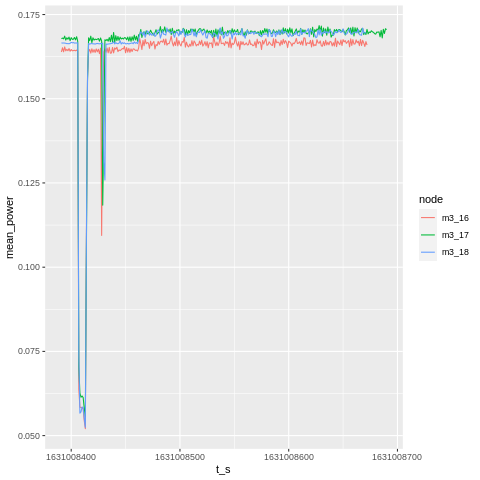

In [25]:
%%R -i df,duration
df %>% filter(t_s > max(t_s) - duration) %>% group_by(t_s, node) %>% summarize(mean_power = mean(power)) %>%  #filter last 5 min
ggplot(aes(x=t_s, y=mean_power, color=node)) + geom_line()

## Cleanup

Stop tunslip on IoT-LAB frontend

In [26]:
en.run('pgrep -u "$(whoami)" tunslip6 | xargs -r kill', fit_frontend) # kill running tunslip if any

None

PLAY [all] *********************************************************************



TASK [pgrep -u "$(whoami)" tunslip6 | xargs -r kill] ***************************


 [started TASK: pgrep -u "$(whoami)" tunslip6 | xargs -r kill on grenoble]


changed: [grenoble]


CommandResult(host='grenoble', task='pgrep -u "$(whoami)" tunslip6 | xargs -r kill', status='OK', payload={'changed': True, 'end': '2021-09-07 11:59:40.322554', 'stdout': '', 'cmd': 'pgrep -u "$(whoami)" tunslip6 | xargs -r kill', 'rc': 0, 'start': '2021-09-07 11:59:40.303746', 'stderr': '', 'delta': '0:00:00.018808', 'invocation': {'module_args': {'creates': None, 'executable': None, '_uses_shell': True, 'strip_empty_ends': True, '_raw_params': 'pgrep -u "$(whoami)" tunslip6 | xargs -r kill', 'removes': None, 'argv': None, 'warn': True, 'chdir': None, 'stdin_add_newline': True, 'stdin': None}}, 'stdout_lines': [], 'stderr_lines': [], 'ansible_facts': {'discovered_interpreter_python': '/usr/bin/python'}, '_ansible_no_log': False})

---
Destroy provider, free resources in testbed.

To re-use the reservation in multiple executions, destroy resources only if it's the last execution (controlled through the free_resources variables).

In [27]:
if free_resources:
    iotlab_provider.destroy()
    g5k_provider.destroy()

[    INFO] : Stopping experiment id (276590)


[    INFO] : Deleting monitoring profile: energy


[    INFO] : Reloading hackathon from grenoble


[    INFO] : Reloading hackathon from lille


[    INFO] : Reloading hackathon from luxembourg


[    INFO] : Reloading hackathon from lyon


[    INFO] : Reloading hackathon from nancy


[    INFO] : Reloading hackathon from nantes


[    INFO] : Reloading hackathon from rennes


[    INFO] : Reloading 1817482 from rennes


[    INFO] : Reloading hackathon from sophia


[    INFO] : Killing the job (rennes, 1817482)
